In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

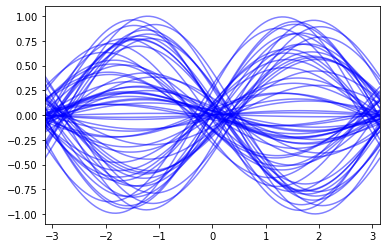

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

In [3]:
type(dataset)

datasets.SineData

In [4]:
dataset

### Build Neural Process

In [5]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

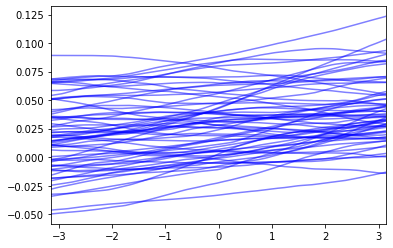

In [6]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [7]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 0.913
iteration 400, loss 5.505
iteration 600, loss 7.374
iteration 800, loss 4.185
iteration 1000, loss 8.195
Epoch: 0, Avg_loss: 3.7697861858736723
iteration 1200, loss 3.261
iteration 1400, loss -3.814
iteration 1600, loss 1.573
iteration 1800, loss 2.331
iteration 2000, loss -4.103
Epoch: 1, Avg_loss: 0.7899854414239526
iteration 2200, loss -6.663
iteration 2400, loss 0.456
iteration 2600, loss 4.408
iteration 2800, loss 4.487
iteration 3000, loss -7.754
Epoch: 2, Avg_loss: -2.0344573323614896
iteration 3200, loss -1.192
iteration 3400, loss -1.103
iteration 3600, loss -1.905
iteration 3800, loss -9.285
iteration 4000, loss -1.683
Epoch: 3, Avg_loss: -3.6585520742461086
iteration 4200, loss -4.358
iteration 4400, loss -5.395
iteration 4600, loss -3.050
iteration 4800, loss -2.987
iteration 5000, loss -4.682
Epoch: 4, Avg_loss: -4.052968414902687
iteration 5200, loss -5.183
iteration 5400, loss -7.984
iteration 5600, loss -2.820
iteration 5800, loss -9.451
iterat

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

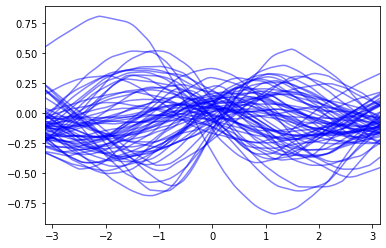

In [8]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

torch.Size([1, 4, 1])
torch.Size([5])
torch.Size([1, 5, 1])


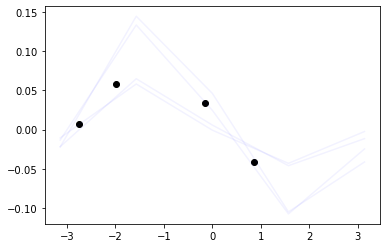

In [18]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# in the context of the SI-simulation, the  context points should be points with known mu and stderr, eg values from the prior
# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

print(np.shape(x_context))

# The target points are the ones we want to get mu and stderr for
# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 5))

print(np.shape(x_target))
x_target = x_target.unsqueeze(1).unsqueeze(0)

print(np.shape(x_target))

neuralprocess.training = False

for i in range(4):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')